# Clustering Time Trends for NYC Businesses

In [1]:
import pandas as pd
import os
import pylab as pl 
import zipfile 
import geopandas as gp
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.spatial.distance import cdist, pdist

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


# 1. Get and Prep Data

### Load NYC Zipcode Data

In [2]:
zip_codes = gp.read_file(os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_codes.rename(columns={'postalCode': 'zip'}, inplace = True)
zip_codes = zip_codes[['PO_NAME','borough','geometry','zip']]
zip_codes['zip'] = zip_codes['zip'].astype(int)
zip_codes.head()

,PO_NAME,borough,geometry,zip
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [3]:
zipsNYC = zip_codes.zip.values

### Load NYC Business Data

In [4]:
#!for ((y=94; y<=100; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#!for ((y=0; y<=10; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [5]:
census = pd.DataFrame()

for i in range(2,10):
    fname = 'zbp0' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    temp_df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    temp_df['year'] = i + 2000
    temp_df.columns = [x.lower() for x in temp_df.columns] #Make all columns lowercase to merge across dfs.
    census = census.append(temp_df) 
    
for i in range(10, 15):
    fname = 'zbp' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    temp_df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    temp_df['year'] = i + 2000
    temp_df.columns = [x.lower() for x in temp_df.columns]
    census = census.append(temp_df) 

for i in range(94, 100):
    fname = 'zbp' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    temp_df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    temp_df['year'] = i + 1900
    temp_df.columns = [x.lower() for x in temp_df.columns] 
    census = census.append(temp_df) 

In [6]:
census = census[['zip','est','year']]

In [7]:
census['zip'] = census['zip'].fillna(0.0).astype(int)
census['zip'] = pd.to_numeric(census.zip).values
census.index = census.zip

In [8]:
census = census.ix[zipsNYC].dropna(how='any')
census.reset_index(drop=True, inplace=True)
census['zip'] = census['zip'].astype(int)
census['year'] = census['year'].astype(int)

In [9]:
census.tail()

,zip,est,year
4791,10282,1.0,1995
4792,10282,11.0,1996
4793,10282,52.0,1997
4794,10282,76.0,1998
4795,10282,88.0,1999


In [10]:
years = list(census.year.values)
zips = list(census.zip.values)

In [11]:
census = census.groupby(['zip', 'year']).mean().unstack()

### Whitening the data

In [12]:
for i in range(0,len(census)):
    census.iloc[i] = (census.iloc[i]-census.iloc[i].mean())/census.iloc[i].std()

census.head()

est                                                              \
year       1994      1995      1996      1997      1998      1999      2002   
zip                                                                           
10001 -1.764192 -1.144618 -1.235118 -0.685159  0.010992 -0.135200 -0.775658   
10002 -1.652385 -1.569152 -1.331345 -1.022195 -1.131587 -0.936585 -0.499020   
10003 -1.822512 -1.448943 -1.325449 -0.961141 -0.609183 -0.578310 -0.711066   
10004 -1.464597 -1.393649 -1.322701 -1.007377 -0.983728 -0.534391 -0.376729   
10005 -2.672540 -2.137862 -0.404207 -0.225981  0.470722  0.017055  0.049460   

                                                                             \
year       2003      2004      2005      2006      2007      2008      2009   
zip                                                                           
10001 -1.172464  0.818527  0.414759  1.131794  2.064636  1.528600  0.366029   
10002 -0.182736  0.171597  0.483124  0.492636  0.490258  0.504527  0.704285   
10003 -0.439379 -0.217090  0.063859  0.193528  0.625757  0.693679  0.780125   
10004 -0.384612 -0.140236 -0.321548  0.080491  0.545594  0.592892  0.616542   
10005 -0.663445 -0.242183 -0.436612  0.292496  0.519329  0.810972  0.535531   

                                                         
year       2010      2011      2012      2013      2014  
zip                                                      
10001 -0.079508 -0.176969 -0.121277  0.143260  0.811565  
10002  0.934958  1.030081  1.129960  1.210814  1.172765  
10003  0.823348  0.965366  1.135170  1.329673  1.502565  
10004  0.766320  0.813619  1.113177  1.404852  1.996084  
10005  0.405912  0.972996  0.519329  0.891984  1.297043

# 2. K-Means

### Calculating the # of Clusters for K-Means

In [13]:
def elbow(data, K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    '''
    Function that calculates and plots the 'elbow' for kmeans clustering. 
    Developed in NYU CUSP's Applied Data Science Class.
    Inputs: data, number of clusters K
    Outputs: Elbow plot
    '''
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [14]:
# Dropping NaN and infinite values 
for i in census:
    census = census[np.isfinite(census[i])]

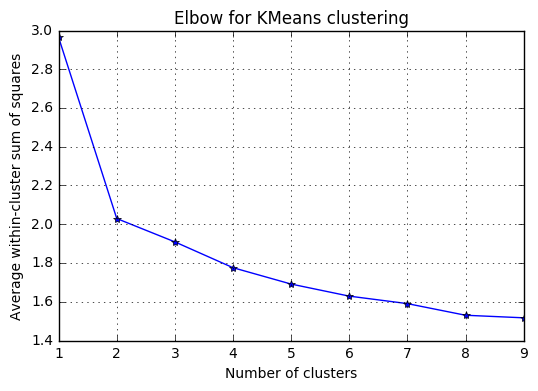

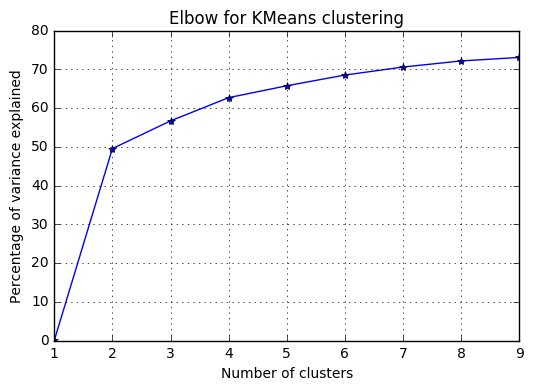

In [15]:
elbow(census, range(1, 10))

**Figure 1.** The figure above plots the elbow method for determining the appropriate number of clusters for K-Means clustering. The bend (elbow) is usually where the ideal number of clusters lie. 

# 3. Plot Cluster Centers

In [16]:
n = 2
km = KMeans(n_clusters = n, random_state = 123)
cluster_labels = km.fit_predict(census)

In [17]:
census['label'] = cluster_labels

cluster_zero = census.loc[census['label'] == 0]
cluster_one = census.loc[census['label'] == 1]

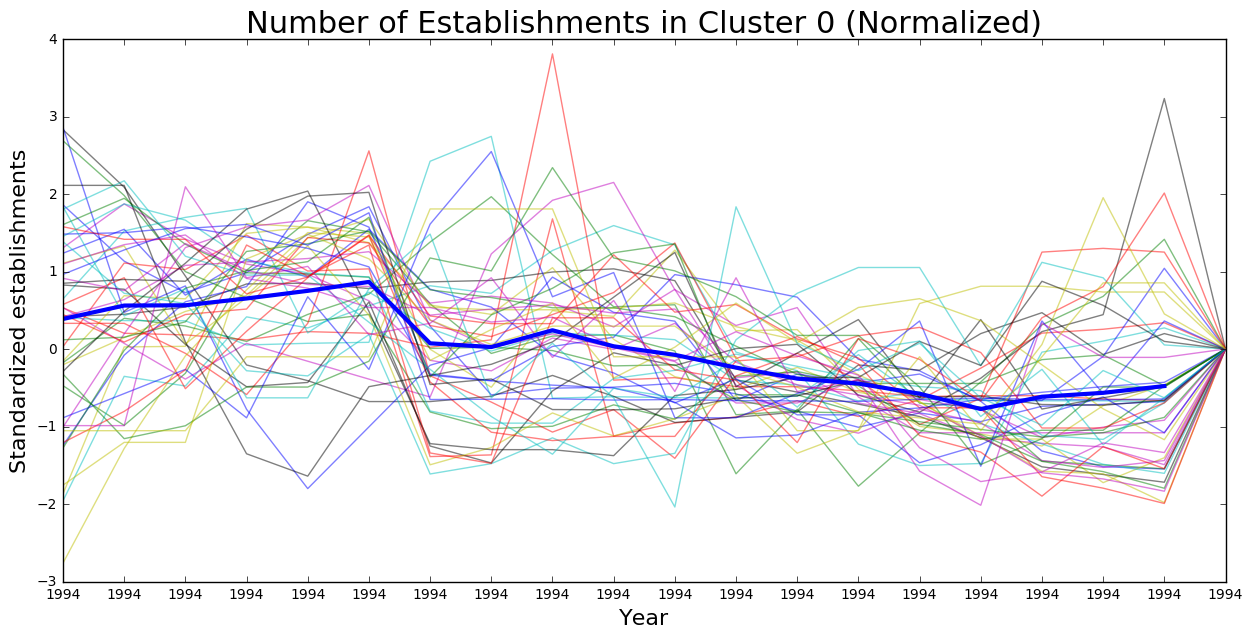

In [18]:
pl.figure(figsize=(15,7))
pl.xticks(np.arange(0,20), sort(years))
for i in range(len(cluster_zero)):
    pl.plot(cluster_zero.iloc[i,:].values, alpha=0.5) 
pl.plot(km.cluster_centers_[0], linewidth=3, color='blue', label='Cluster centroids')
pl.title('Number of Establishments in Cluster 0 (Normalized)', size=22)
pl.xlabel('Year', size=16)
pl.ylabel('Standardized establishments', size=16)

**Figure 2.** The figure above plots the normalized number of establishments in cluster 0 over the years of 1994 to 2014, as represented in the data. The trend represents an increase then slow and steady descrease as the data approaches the year 2014. 

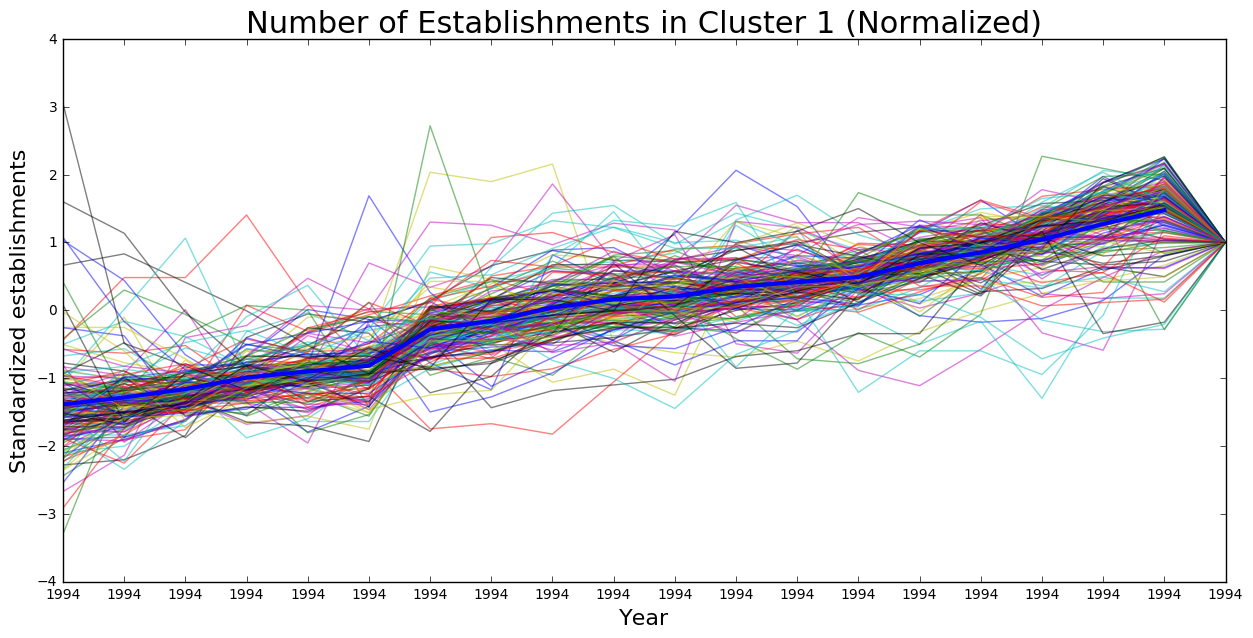

In [19]:
pl.figure(figsize=(15,7))
pl.xticks(np.arange(0,20), sort(years))
for i in range(len(cluster_one)):
    plt.plot(cluster_one.iloc[i,:].values, alpha=0.5) 
pl.plot(km.cluster_centers_[1], linewidth=3, color='blue', label='Cluster centroids')
pl.title('Number of Establishments in Cluster 1 (Normalized)', size=22)
pl.xlabel('Year', size=16)
pl.ylabel('Standardized establishments', size=16)
#@Review: Needed more clusters as per step 2

**Figure 3.** The figure above plots the normalized number of establishments in cluster 1 over the years of 1994 to 2014, as represented in the data. The trend represents a constant increase in the number of establishments from 1994 to 2014.

# 4. Agglomerative Clustering

In [20]:
n = 2
agl = AgglomerativeClustering(n_clusters = n)
agl_cluster_labels = agl.fit_predict(census)

In [21]:
unique(agl_cluster_labels)

array([0, 1])

In [22]:
census['agl'] = agl_cluster_labels

agl_cluster_zero = census.loc[census['agl'] == 0]
agl_cluster_one = census.loc[census['agl'] == 1]

# 5. Plot the Clusters

### Merge the Data Sets

In [23]:
shape(zip_codes)
#@Review: Cluster not rendered!?

(262, 4)

In [24]:
shape(cluster_labels)

(230,)

In [25]:
census['zip'] = census.index

In [26]:
zips = list(census.index)
cluster_map = pd.DataFrame({'zip':zips, 'label':cluster_labels, 'agl':agl_cluster_labels})

In [27]:
cluster_map = pd.merge(zip_codes, cluster_map, on = 'zip', how = 'left')
cluster_map.dropna(how = 'any')
cluster_map.head()

,PO_NAME,borough,geometry,zip,agl,label
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1.0,1.0
1,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,1.0,1.0
2,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1.0,1.0
3,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0.0,1.0
4,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,1.0,1.0


### K-Means Clustering Map

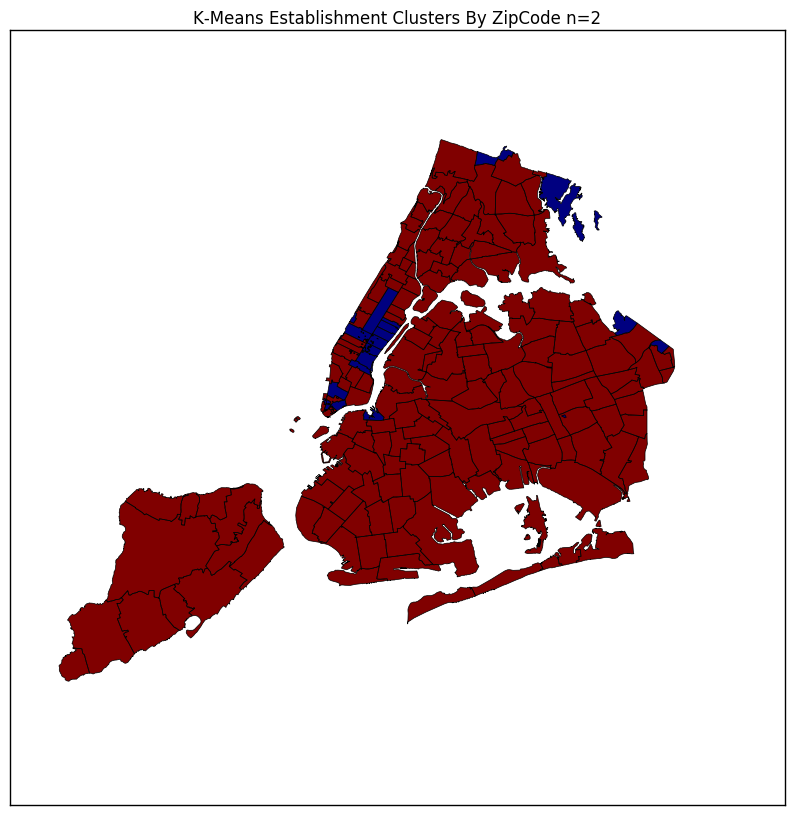

In [31]:
f, ax = pl.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_map.plot(column='label',alpha=1,linewidth=0.5,ax=ax)
pl.title('K-Means Establishment Clusters By ZipCode n=2')

**Figure 4.** The figure above depicts the normalized establishments in clusters 0 and 1, across NYC by zip code. The clusters are formed using the K-Means clustering method. 

### Agglomerative Clustering Map

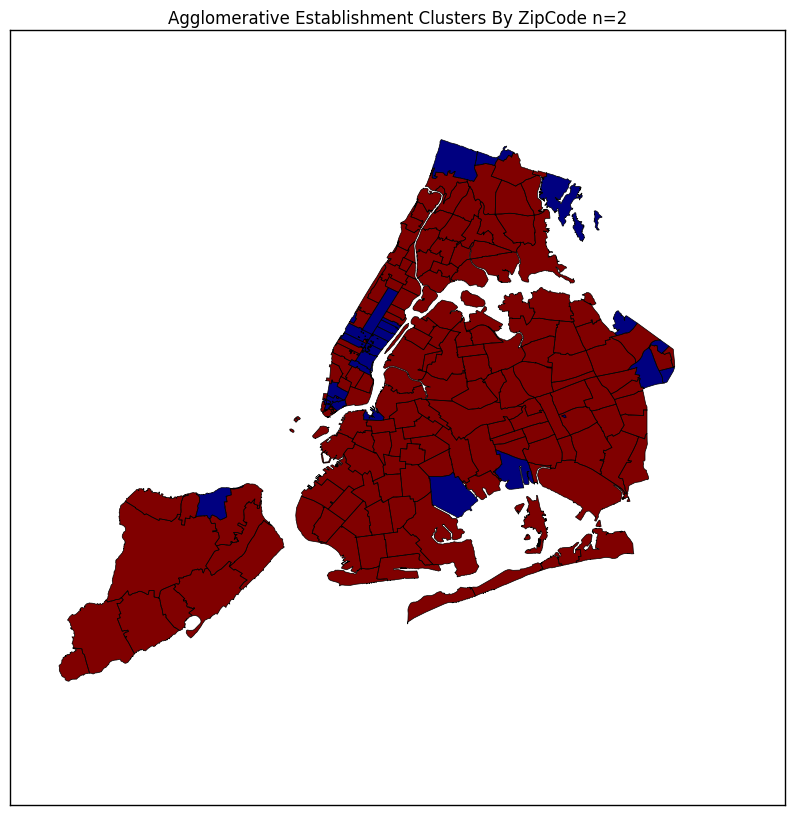

In [29]:
f, ax = pl.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_map.plot(column='agl',alpha=1,linewidth=0.5,ax=ax)
pl.title('Agglomerative Establishment Clusters By ZipCode n=2')

**Figure 5.** The figure above depicts the normalized establishments in clusters 0 and 1, across NYC by zip code. The clusters are formed using the Agglomerative clustering method. This figure has clustered the establishments slightly differnt than the K-Means algorithm, but the results are fairly similar. 

# 6. Compare Results of 2 Algorithms 

The K-Means and Agglomerative clustering methods yield slightly different, but relatively consistent results.

# 7. Interpretation

Both clustering methods clearly pinpoint the upper East Side, Tribeca, Brooklyn Navy Yard, Yonkers, and a few other areas as those having increased in the number of establishments since 1994. This appears to be pretty accurate considering there have been significant changes to those areas in recent years. These areas have either been gentrified or have seen a spring up in commercial and retail businesses, along with high rise buildings. 

The Agglomerative clustering method groups Canarsie, Howard Beach, and a neighborhood in Staten Island among those having had increases in establishments since 1994. 